In [90]:
from Evolution import *
import random

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 

from tqdm import tqdm

import torch 
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [91]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                   names=['s_length','s_width','p_length','p_width','y'])
data['y'] = data['y'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data

,s_length,s_width,p_length,p_width,y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [92]:
class MyDataset(Dataset):
  def __init__(self, df): 
    x=df.iloc[:,0:4].values
    y=df.iloc[:,4].values
 
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.long)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


dataset = MyDataset(data)
train_dataset, test_dataset = random_split(dataset, (120, 30))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=10) 

In [112]:
class ANN(nn.Module):
    def __init__(self, n=5):
        super(ANN, self).__init__()
        self.linear1 = nn.Linear(4, n)
        self.out = nn.Linear(n, 3)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.out(x)
        return x

In [143]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 

In [144]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    iteration = 0
    overall_loss = 0 
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data).softmax(dim=1)

        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        iteration += 1
        overall_loss += loss.item()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)
    # print(f"Test set: Average loss: {test_loss}, Accuracy: {100. * correct / len(test_loader.dataset)} ")
    return 100. * correct / len(test_loader.dataset)

In [146]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['network_architecure'] = self._network_architecure.crossover(other._network_architecure)

        new['lr'] = (self['lr'] + other['lr']) / 2

        new['epochs'] = random.choice([self['epochs'], other['epochs']])

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.lr = new._lr.get()
        else:
            new.lr = self.lr

        if random.random() < rate:
            new.network_architecure = new._network_architecure.mutate()
        else:
            new.network_architecure = self.network_architecure

        if random.random() < rate:
            new.epochs = new._epochs.get()
        else:
            new.epochs = self.epochs
        return new

chromosome_factory = ChromosomeClassFactory(
        network_architecure={'n': list([1, 1]), 'range': list(range(3, 60))},
        lr=(1e-5, 1e-3), 
        epochs=list(range(2, 20))
    )

In [220]:
import torch.optim as optim
from math import log

def evaluate_model(chromosome, show_metric=False): 
    n_iterations = 5
    metric = 0
    for _ in range(n_iterations): 
        model = ANN(chromosome.network_architecure[0]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=chromosome.lr)
        
        for epoch in range(chromosome.epochs):
            train(model, device, train_loader, optimizer, epoch)

        metric += test(model, device, test_loader)
    metric /= n_iterations
    
    if show_metric: 
        print(f'{metric=}')
        
    return metric - (log(log(chromosome.epochs) + chromosome.network_architecure[0]**0.1))

In [221]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 180
best = [None, -float('inf')]

In [222]:
# need for statistic collection 
statistic_best = []
statistic_mean = []

statistic_n_epochs = []
statistic_lr = []
statistic_middle_layer_size = []

# Evolutionary algorithm 

# initial population initialisation 
population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append([c, None])

# evolution process 
for _ in tqdm(range(ITERATIONS)):
    # scoring each chromosome 
    for instance in population:
        if instance[1] is None:
            instance[1] = evaluate_model(instance[0])

    # selection of best instances 
    population = sorted(population, key=lambda x: x[1], reverse=True)[:POPULATION_SIZE // 3]

    statistic_best.append(population[0][1])
    statistic_mean.append(sum(map(lambda x: x[1], population)) / POPULATION_SIZE)
    
    statistic_n_epochs.append(population[0][0].epochs)
    statistic_lr.append(population[0][0].lr)
    statistic_middle_layer_size.append(population[0][0].network_architecure[0])

    # checking for the best solution 
    if population[0][1] > best[1]:
        best = population[0]

    # filling the population with new genes 
    while len(population) < POPULATION_SIZE:
        r = random.random()
        if r < 0.33:
            population.append([random.choice(population)[0].crossover(random.choice(population)[0]), None])
        elif 0.33 <= r < 0.66:
            population.append([random.choice(population)[0].mutate(), None])
        else:
            population.append([chromosome_factory.generate(MyChromosome), None])

100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [1:50:20<00:00, 36.78s/it]


In [223]:
print(best[0], f'{best[1]:_}', sep='\n')
evaluate_model(best[0], True)

--Chromosome--
network_architecure: (55,)
lr: 0.0008988951313553635
epochs: 19

89.8432741653625
metric=79.33333333333334


77.8432741653625

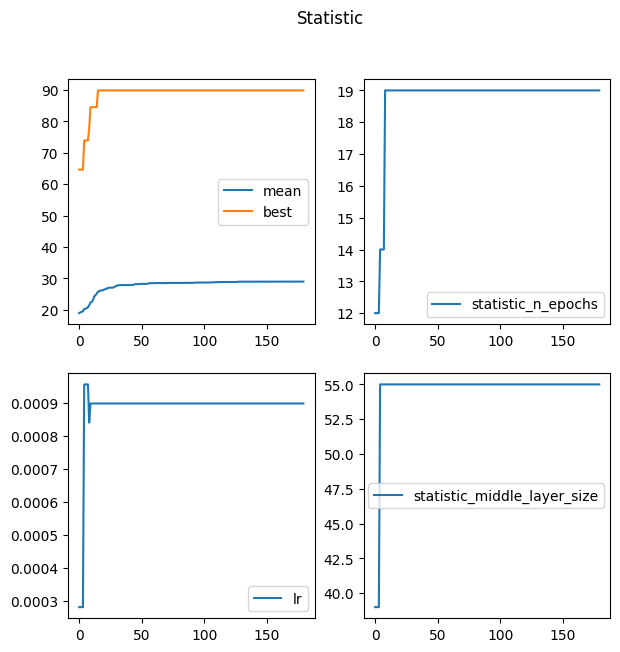

In [224]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
fig.suptitle('Statistic')

plt.subplot(2, 2, 1)
plt.plot(statistic_mean, label='mean')
plt.plot(statistic_best, label='best')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(statistic_n_epochs, label='statistic_n_epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(statistic_lr, label='lr')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(statistic_middle_layer_size, label='statistic_middle_layer_size')
plt.legend()

plt.show()